# Redes Neurais Convulacionais - Introdução

As Redes Neurais Convolucionais (CNNs) são uma classe especial de redes neurais projetadas para processar dados que têm um grid-like topology, como imagens. Inspiradas na organização do córtex visual de animais, as CNNs são particularmente eficazes no reconhecimento de padrões espaciais e estruturais em dados visuais.

### Estrutura das CNNs

As CNNs consistem em várias camadas, cada uma desempenhando um papel específico no processamento dos dados:

1. **Camadas Convolucionais:**
   - Realizam operações de convolução sobre os dados de entrada, aplicando filtros (ou kernels) que percorrem a imagem, produzindo mapas de características.
   - https://setosa.io/ev/image-kernels/
   - Cada filtro é treinado para detectar diferentes características, como bordas, texturas ou objetos específicos.
   - A operação de convolução preserva a relação espacial entre pixels, permitindo que a rede aprenda padrões locais.

2. **Camadas de Pooling:**
   - Reduzem a dimensionalidade dos mapas de características, resumindo a informação em regiões locais.
   - A operação de pooling mais comum é o Max Pooling, que seleciona o valor máximo em cada região do mapa de características.
   - Pooling ajuda a reduzir a complexidade computacional e a prevenir overfitting.

3. **Camadas de Ativação:**
   - Introduzem não-linearidade na rede, permitindo que ela aprenda funções complexas.
   - A função de ativação mais comum em CNNs é a ReLU (Rectified Linear Unit), que substitui valores negativos por zero.

4. **Camada de Flattening**
   - Etapa que realça as características do que está sendo treinado.
   - Existe o max pulling, que pega um grupo de pixels e realça o maior valor
      - Reduz ainda mais a dimensão da imagem, realçando as características principais.
      - Auxilia a reduzir o overfitting e ruídos desnecessários
   - Existe também o min pulling, e o valor médio do pulling.

5. **Camadas Completamente Conectadas (Fully Connected):**
   - Análoga as redes neurais convecionais com camada Densa
   - Situadas nas camadas finais da rede, essas camadas conectam todos os neurônios da camada anterior com todos os neurônios da camada seguinte.
   - São responsáveis por combinar as características aprendidas para produzir a saída final, como a classificação da imagem.

### Funcionamento

1. **Propagação Direta (Forward Propagation):**
   - A imagem de entrada é processada por várias camadas convolucionais e de pooling, onde as características são extraídas e a dimensionalidade é reduzida.
   - Os mapas de características resultantes são então achatados e passados para camadas completamente conectadas, que combinam essas características para gerar a saída final.

2. **Treinamento:**
   - O treinamento é realizado usando o algoritmo de retropropagação (backpropagation) para minimizar a função de perda.
   - Os pesos dos filtros e das conexões totalmente conectadas são ajustados para reduzir o erro entre as previsões da rede e os valores reais.
   - O gradiente descendente e suas variantes, como o Adam optimizer, são comumente usados para atualizar os pesos.

### Aplicações e Vantagens

As CNNs são extremamente eficazes em tarefas de visão computacional, como reconhecimento de objetos, detecção de rostos, segmentação de imagens e análise de vídeo. Suas vantagens incluem:

- **Eficiência Computacional:** Aproveitam a estrutura local dos dados para reduzir o número de parâmetros e melhorar a eficiência do treinamento.
- **Capacidade de Generalização:** Podem aprender características hierárquicas, desde padrões simples até complexas representações abstratas.
- **Robustez a Translações:** A operação de pooling e a natureza convolucional tornam as CNNs robustas a pequenas translações e deformações nos dados de entrada.

Em resumo, as CNNs são uma ferramenta poderosa e versátil para o processamento de dados visuais, impulsionando avanços significativos em várias áreas da inteligência artificial e do aprendizado de máquina.

# CNN - Exemplo usando Keras (Tensorflow)

In [1]:
import os
# To RUN Tensolflow with CPU, set the environment variable 'CUDA_VISIBLE_DEVICES' to -1. 
## Otherwise it will run with GPU (comment the line above).
# os.environ['CUDA_VISIBLE_DEVICES'] = "-1"

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from sklearn.datasets import fetch_olivetti_faces
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

from keras.api.models import Sequential
from keras.api.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, BatchNormalization, Dropout
from keras.api.layers import Resizing, Rescaling, Reshape, RandomFlip, RandomRotation
from keras.api.utils import to_categorical
from keras.api.metrics import categorical_accuracy

from scikeras.wrappers import KerasClassifier

2024-07-23 13:52:59.451955: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-07-23 13:52:59.731457: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-23 13:52:59.842315: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-23 13:52:59.873957: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-23 13:53:00.096987: I tensorflow/core/platform/cpu_feature_guar

## Olivietti Faces

In [13]:
# https://scikit-learn.org/stable/modules/generated/sklearn.datasets.fetch_olivetti_faces.html
X, y = fetch_olivetti_faces(return_X_y=True)

In [14]:
# Imagens com 400 exemplares de cada rosto no formato (64, 64)
print(X.shape, y.shape)

(400, 4096) (400,)


In [15]:
print(X[0][:10])

[0.30991736 0.3677686  0.41735536 0.44214877 0.5289256  0.607438
 0.6570248  0.677686   0.69008267 0.6859504 ]


## Tratando os dados

In [16]:
reshape_resize_fn = Sequential([
    # Estammos convertendo o array 4096 para (64, 64, 1). Formato indicado pela documentação
    Reshape((64, 64, 1)),
    # Diminuindo o tamanho da imagem para reduzir a capacidade computacional
    Resizing(height=32, width=32, data_format="channels_last", dtype=np.float32),
    # Já está escalado entre 0 e 1.
    # Rescaling(1./255) 
])

X_reshaped = reshape_resize_fn(X)

In [17]:
print(X_reshaped.shape)

(400, 32, 32, 1)


In [18]:
# Aqui vemos que esta em um formato descritivo. Precisamos categorizar a saída para um formato OneHotEncoded.
## É feito isso para colocar X neuronios na saída do modelo de modo que indique a possibilidade de ser aquela classe.
print(y[0:50])
print(y.shape)

num_classes = np.unique(y).shape[0]
y_categorized = to_categorical(y, num_classes=num_classes)

print("\n")
print(y_categorized[0])
print(y_categorized.shape)

[0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 3 3 3 3 3 3 3
 3 3 3 4 4 4 4 4 4 4 4 4 4]
(400,)


[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
(400, 40)


## Aumentando o número de amostrars (Data Augmentation)

In [19]:
data_augmentation = Sequential([
    RandomFlip("horizontal"),
    RandomRotation(0.2),
])

X_reshaped_augmented = X_reshaped
y_categorized_augmented = y_categorized

for i in range(X_reshaped.shape[0]):
    image = X_reshaped[i]
    label = y_categorized[i]

    # Para cada imagem do dataset vamos gerar uma nova com rotação e inversão aleatória.
    ## Isso implica que vamos dobrar o número de amostras.
    augmented_data = data_augmentation(image)
    X_reshaped_augmented = np.append(X_reshaped_augmented, np.array([augmented_data]), axis=0)
    y_categorized_augmented = np.append(y_categorized_augmented, np.array([label]), axis=0)


In [20]:
print(X_reshaped_augmented.shape)
print(y_categorized_augmented.shape)

(800, 32, 32, 1)
(800, 40)


## Visualizando imagens aleatórias

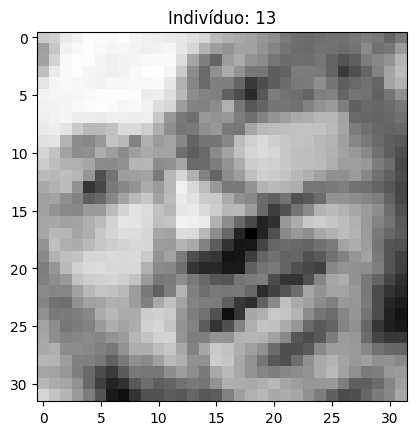

In [21]:
index = np.random.randint(0, X_reshaped_augmented.shape[0])

image = X_reshaped_augmented[index]
label = y_categorized_augmented[index]

plt.imshow(image, cmap='gray')
plt.title(f'Indivíduo: {np.argmax(label)}')
plt.show()

## Separando dados de treinamento e teste

In [22]:
# Separando os dados de teste (20%) e treinamento (80%) de forma aleatória.
X_train, X_test, y_train, y_test = train_test_split(
    X_reshaped_augmented, 
    y_categorized_augmented, 
    test_size=0.2, 
    shuffle=True
)

## Criando o modelo

In [64]:
print(X_train.shape)

(640, 32, 32, 1)


In [84]:
def criar_modelo(num_entradas, num_classes):
    model = Sequential(
        name="Olivetti_Faces",
        layers=[
            # Definimos um input com o formato das imagens dentro dos dados de treinamento. (32, 32, 1)
            Input(
                shape=num_entradas
            )
        ]
    )

    # 1ª Etapa - Operador de convolução
    model.add(
        Conv2D(
            # Número de dectores de características. Ideal é começar com 64 kernels e ir aumentando seguindo base 2.
            filters=128,
            # Pensando que é imagem pequena. Imagens maiores usar kernel maiores.
            kernel_size=(3, 3),
            # Movimenta 1 pixel para direita e 1 pixel para baixo respectivamente
            strides=(1, 1),
            # ativação recomendada para aplicações com imagem (ReLU)
            activation='relu'
        )
    )

    # 2ª Etapa - Operador Pooling
    model.add(
        MaxPooling2D(
            # Janela que seleciona os dados dentro do mapa de características (resultado convolução)
            pool_size=(2, 2)
        )
    )

    # Camada Extra de convolução
    model.add(
        Conv2D(
            filters=64,
            kernel_size=(3, 3),
            strides=(1, 1),
            activation='relu'
        )
    )
    model.add(
        MaxPooling2D(
            pool_size=(4, 4)
        )
    )

    # 3ª Etapa - Operador Flatten (transorma matriz em vetor) (Deve ser apenas no final das camadas de convolução)
    model.add(
        Flatten()
    )

    # 4ª Etapa - Rede Neural Densa
    model.add(
        Dense(
            units=308,
            activation='relu',
        )
    )
    model.add(
        Dropout(0.25)
    )

    model.add(
        Dense(
            units=308,
            activation='relu',
        )
    )
    model.add(
        Dropout(0.25)
    )
    
    model.add(
        Dense(
            units=num_classes,
            activation='softmax'
        )
    )

    model.compile(
        optimizer='adam',
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

network = criar_modelo(
    num_entradas=X_train.shape[1:],
    num_classes=y_train.shape[1]
)

network.summary()


Model: "Olivetti_Faces"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_96 (Conv2D)              │ (None, 30, 30, 128)    │         1,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_96 (MaxPooling2D) │ (None, 15, 15, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_97 (Conv2D)              │ (None, 13, 13, 64)     │        73,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_97 (MaxPooling2D) │ (None, 3, 3, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_48 (Flatten)            │ (None, 576)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_144 (Dense)               │ (None, 308)            │       177,716 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_96 (Dropout)            │ (None, 308)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_145 (Dense)               │ (None, 308)            │        95,172 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_97 (Dropout)            │ (None, 308)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_146 (Dense)               │ (None, 40)             │        12,360 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 360,320 (1.37 MB)

 Trainable params: 360,320 (1.37 MB)

 Non-trainable params: 0 (0.00 B)

## Treinando e validando o modelo

In [66]:
historico = network.fit(
    x=X_train,
    y=y_train,
    # Se estiver rodando com a CPU, inicie com epochs pequenas (100), por conta de levar mais tempo
    epochs=200,
    batch_size=24,
    # Usamos dados de teste para avaliar o desempenho do modelo a cada epoch que é rodada
    validation_data=(X_test, y_test)
)

Epoch 1/200
27/27 ━━━━━━━━━━━━━━━━━━━━ 7s 132ms/step - accuracy: 0.0169 - loss: 3.7009 - val_accuracy: 0.0125 - val_loss: 3.6946
Epoch 2/200
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.0297 - loss: 3.6885 - val_accuracy: 0.0250 - val_loss: 3.7015
Epoch 3/200
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.0237 - loss: 3.6880 - val_accuracy: 0.0125 - val_loss: 3.7017
Epoch 4/200
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.0239 - loss: 3.6877 - val_accuracy: 0.0188 - val_loss: 3.7030
Epoch 5/200
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.0215 - loss: 3.6831 - val_accuracy: 0.0125 - val_loss: 3.7087
Epoch 6/200
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.0297 - loss: 3.6760 - val_accuracy: 0.0125 - val_loss: 3.7047
Epoch 7/200
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.0241 - loss: 3.6712 - val_accuracy: 0.0125 - val_loss: 3.7003
Epoch 8/200
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.0363 - loss: 3.6280 - val_accuracy: 0.0312 -

Treinamento - Custo:  0.4995238583348691
Treinamento - Acurácia:  0.8527109383791686
Teste - Custo:  1.4339425033330917
Teste - Acurácia:  0.6811562490696087


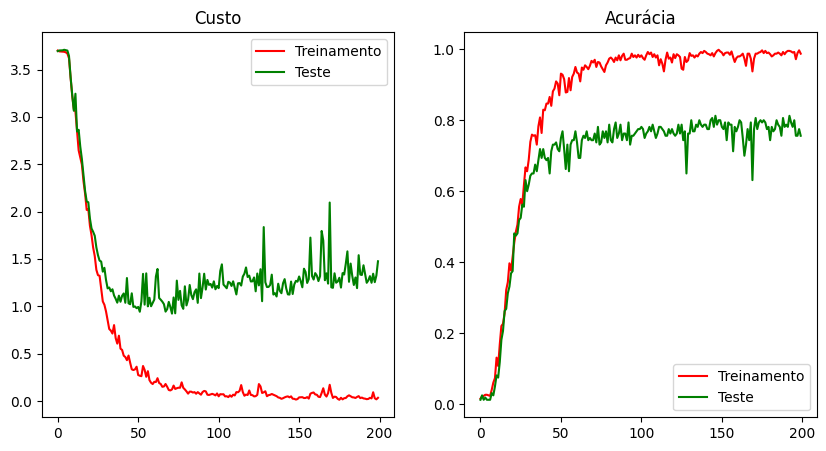

In [67]:
print("Treinamento - Custo: ", np.mean(historico.history['loss']))
print("Treinamento - Acurácia: ", np.mean(historico.history['accuracy']))
print("Teste - Custo: ", np.mean(historico.history['val_loss']))
print("Teste - Acurácia: ", np.mean(historico.history['val_accuracy']))

fig, (ax1, ax2) = plt.subplots(figsize=(10, 5), nrows=1, ncols=2)

ax1.plot(historico.history['loss'], 'r-', label='Treinamento')
ax1.plot(historico.history['val_loss'], 'g-', label='Teste')
ax1.legend()
ax1.set_title('Custo')

ax2.plot(historico.history['accuracy'], 'r-', label='Treinamento')
ax2.plot(historico.history['val_accuracy'], 'g-', label='Teste')
ax2.legend()
ax2.set_title('Acurácia')

plt.show()

## Validando o modelo fora do treinamento

In [68]:
predict = network.predict(X_test)

cat_accuracy = categorical_accuracy(
    y_true=y_test, 
    y_pred=predict
)

accuracy = accuracy_score(
    y_true=y_test.argmax(axis=1),
    y_pred=predict.argmax(axis=1)
)

print("Caregorical Accuracy: ", np.mean(cat_accuracy.numpy()))
print("Accuracy: ", np.mean(accuracy))


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step  
Caregorical Accuracy:  0.75625
Accuracy:  0.75625


In [69]:
report = classification_report(
    y_true=y_test.argmax(axis=1),
    y_pred=predict.argmax(axis=1)
)
print(report)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         2
           1       1.00      0.50      0.67         6
           2       0.50      0.50      0.50         6
           3       0.55      1.00      0.71         6
           4       0.60      1.00      0.75         3
           5       1.00      1.00      1.00         4
           6       1.00      0.75      0.86         4
           7       0.40      1.00      0.57         2
           8       1.00      0.83      0.91         6
           9       0.80      0.67      0.73         6
          10       1.00      1.00      1.00         5
          11       0.25      0.50      0.33         2
          12       1.00      0.40      0.57         5
          13       1.00      1.00      1.00         4
          14       0.75      0.50      0.60         6
          15       1.00      0.60      0.75         5
          16       0.50      0.75      0.60         4
          17       0.67    

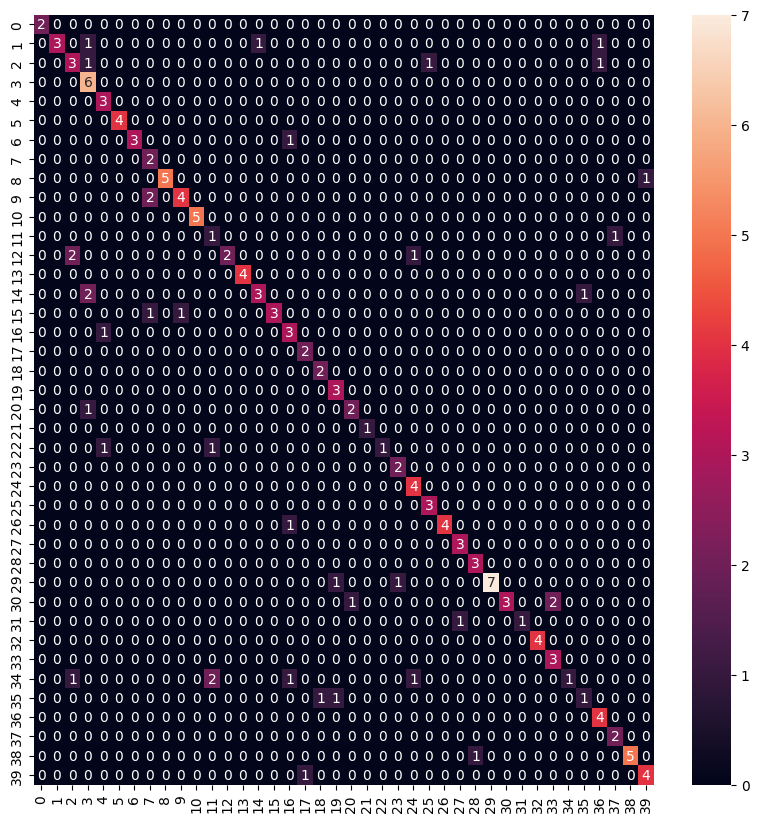

In [70]:
cm = confusion_matrix(
    y_true=y_test.argmax(axis=1),
    y_pred=predict.argmax(axis=1)
)

plt.figure(figsize=(10, 10))
sns.heatmap(cm, annot=True)
plt.show()

## Otimizando o modelo

* Nota-se que alguns rostos não tiveram nenhuma detecção correta. Isso pode ser resolvido com uma rede neural mais robusta.
    * Quando se fala em robustez, entende-se em adicionar novas camadas e testar outras topologias para identificar as classes 
* Outra opção é otimizar o parâmetros da rede usando GridSearchCV
* Outra opção é treinar a rede usando CrossValidation

### Recriando o Modelo

In [23]:
def criar_modelo_otimizado(num_entradas, num_classes, dropout=0.25, conv_filters=128, neurons_dense=308, num_conv=2, num_dense=2):
    model = Sequential(
        name="Olivetti_Faces",
        layers=[
            Input(
                shape=num_entradas
            )
        ]
    )

    for _ in range(num_conv):
        model.add(
            Conv2D(
                filters=conv_filters,
                kernel_size=(3, 3),
                strides=(1, 1),
                activation='relu'
            )
        )
        # Normaliza os dados gerados pela convolução, isso auxilia a rede a entender melhor os dados
        model.add(
            BatchNormalization()
        )
        model.add(
            MaxPooling2D(
                pool_size=(2, 2)
            )
        )
        
    model.add(
        Flatten()
    )

    for _ in range(num_dense):
        model.add(
            Dense(
                units=neurons_dense,
                activation='relu',
            )
        )
        model.add(
            Dropout(dropout)
        )
        
    
    model.add(
        Dense(
            units=num_classes,
            activation='softmax'
        )
    )

    model.compile(
        optimizer='adam',
        loss='categorical_crossentropy',
        metrics=['categorical_accuracy']
    )

    return model

network = criar_modelo_otimizado(
    num_entradas=X_train.shape[1:],
    num_classes=y_train.shape[1]
)

network.summary()


Model: "Olivetti_Faces"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 30, 30, 128)    │         1,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 30, 30, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 15, 15, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 13, 13, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 13, 13, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 6, 6, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 4608)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 308)            │     1,419,572 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 308)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 308)            │        95,172 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 308)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 40)             │        12,360 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,676,992 (6.40 MB)

 Trainable params: 1,676,480 (6.40 MB)

 Non-trainable params: 512 (2.00 KB)

### Cross Validation

* Teoria: https://machinelearningmastery.com/k-fold-cross-validation/

* Resumo: Vai separar os dados em N grupos, e irá separa 1 deles fa zer a validação. Vai rodar o modelo N vezes, e vai pegar o melhor resultado.

In [89]:
y_categorized_augmented.argmax(axis=1).shape

(800,)

In [101]:
crossValidation = StratifiedKFold(
    n_splits=5,
    shuffle=True,
)

resultados = []

# Separa a base de dados de treinamento em grupos de teste e treinamento. Nesse caso n_splits=5.
## É feita a interação por cada grupo para achar valores mais precisos e reais de pesos para a rede.
for indice_treinamento, indice_teste in crossValidation.split(X_reshaped_augmented, y_categorized_augmented.argmax(axis=1)):
    classificador = criar_modelo_otimizado(
        num_entradas=X_reshaped_augmented.shape[1:],
        num_classes=y_categorized_augmented.shape[1]
    )
    classificador.fit(
        x=X_reshaped_augmented[indice_treinamento],
        y=y_categorized_augmented[indice_treinamento],
        batch_size=24,
        epochs=200
    )

    precisao = classificador.evaluate(
        x=X_reshaped_augmented[indice_teste],
        y=y_categorized_augmented[indice_teste]
    )

    resultados.append(precisao)

Epoch 1/200
27/27 ━━━━━━━━━━━━━━━━━━━━ 5s 76ms/step - categorical_accuracy: 0.0834 - loss: 4.3226
Epoch 2/200
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - categorical_accuracy: 0.2279 - loss: 2.8950
Epoch 3/200
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - categorical_accuracy: 0.4374 - loss: 2.0029
Epoch 4/200
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - categorical_accuracy: 0.6131 - loss: 1.3621
Epoch 5/200
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - categorical_accuracy: 0.7056 - loss: 1.0558
Epoch 6/200
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - categorical_accuracy: 0.7617 - loss: 0.8083
Epoch 7/200
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - categorical_accuracy: 0.7926 - loss: 0.6816
Epoch 8/200
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - categorical_accuracy: 0.8412 - loss: 0.4872
Epoch 9/200
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - categorical_accuracy: 0.8841 - loss: 0.3574
Epoch 10/200
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - categorical_accuracy: 0.9274 - loss: 0.2542
Epoch 11/200
27/27 

Custo médio:  4.962233638763427
Acurácia médio:  0.625


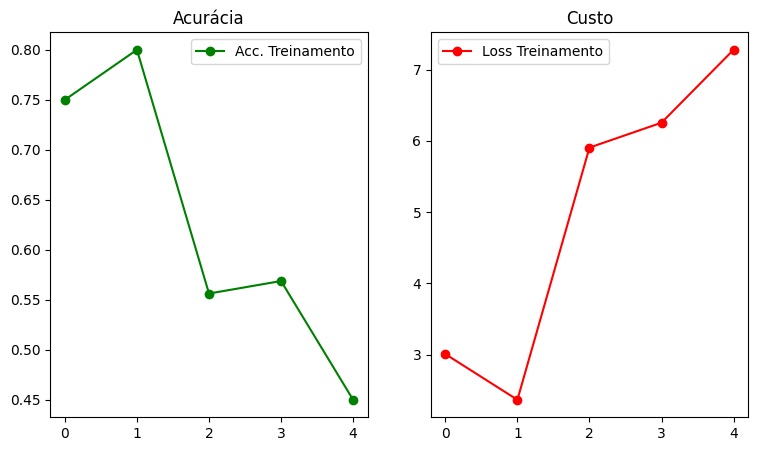

In [102]:
resultados = np.array(resultados)
custo = resultados[:, 0]
acuracia = resultados[:, 1]

print("Custo médio: ", custo.mean())
print("Acurácia médio: ", acuracia.mean())

fig, (ax1, ax2) = plt.subplots(
    figsize=(9, 5),
    nrows=1,
    ncols=2
)

ax1.set_title("Acurácia")
ax1.plot(acuracia, 'go-', label="Acc. Treinamento")
ax1.legend()

ax2.set_title("Custo")
ax2.plot(custo, 'ro-', label="Loss Treinamento")
ax2.legend()

plt.show()

### Cross Validation com KerasClassifier

In [103]:
classifier = KerasClassifier(
    model=criar_modelo_otimizado,
    epochs=200,
    batch_size=24,
    # 'criar_modelo' parameters
    num_entradas=X_reshaped_augmented.shape[1:],
    num_classes=y_categorized_augmented.shape[1]
)

K=10
resultados = cross_val_score(
    estimator=classifier,
    X = X_reshaped_augmented,
    y = y_categorized_augmented,
    cv = K
)

Epoch 1/200
30/30 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - categorical_accuracy: 0.0826 - loss: 4.4414
Epoch 2/200
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - categorical_accuracy: 0.2451 - loss: 2.8571
Epoch 3/200
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - categorical_accuracy: 0.4365 - loss: 2.1081
Epoch 4/200
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - categorical_accuracy: 0.5839 - loss: 1.4197
Epoch 5/200
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - categorical_accuracy: 0.7424 - loss: 0.8862
Epoch 6/200
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - categorical_accuracy: 0.7971 - loss: 0.6842
Epoch 7/200
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - categorical_accuracy: 0.8495 - loss: 0.4803
Epoch 8/200
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - categorical_accuracy: 0.9088 - loss: 0.3248
Epoch 9/200
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - categorical_accuracy: 0.8991 - loss: 0.3647
Epoch 10/200
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - categorical_accuracy: 0.9037 - loss: 0.3518
Epoch 11/200
30/30 

In [ ]:
scores = resultados

print("Acurácia médio: ", scores.mean())
print(scores)

Acurácia médio:  0.3275


### GridSearchCV

* https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html
* https://towardsdatascience.com/gridsearchcv-for-beginners-db48a90114ee

In [26]:
classifier = KerasClassifier(
    model=criar_modelo_otimizado
)

# Cada item dentro da lista sera testado seguindo a lógica todos com todos
options = {
    'batch_size': [24, 12],
    'epochs': [200, 100],
    'verbose': [1],
    'model__num_entradas': [X_reshaped_augmented.shape[1:]],
    'model__num_classes': [y_categorized_augmented.shape[1]],
    'model__dropout': [0.25],
    'model__num_conv': [2],
    'model__conv_filters': [128],
    'model__num_dense': [2],
    'model__neurons_dense': [308]
}

K = 2 # Número de grupos/repetições que serão feitas no dataset
optimizer = GridSearchCV(
    estimator = classifier,
    param_grid = options,
    cv=K
)

In [27]:
result = optimizer.fit(
    X=X_reshaped_augmented,
    y=y_categorized_augmented
)

Epoch 1/200


I0000 00:00:1721753697.359589  242155 service.cc:146] XLA service 0x5555f083ff00 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1721753697.359632  242155 service.cc:154]   StreamExecutor device (0): NVIDIA GeForce MX450, Compute Capability 7.5
2024-07-23 13:54:57.401217: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-07-23 13:54:57.589632: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8907


16/17 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - categorical_accuracy: 0.0576 - loss: 4.8257  

I0000 00:00:1721753700.967411  242155 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


17/17 ━━━━━━━━━━━━━━━━━━━━ 8s 187ms/step - categorical_accuracy: 0.0592 - loss: 4.8024
Epoch 2/200
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - categorical_accuracy: 0.1761 - loss: 3.4721
Epoch 3/200
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - categorical_accuracy: 0.2074 - loss: 3.0680
Epoch 4/200
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - categorical_accuracy: 0.3333 - loss: 2.2389
Epoch 5/200
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - categorical_accuracy: 0.5208 - loss: 1.8369
Epoch 6/200
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - categorical_accuracy: 0.5936 - loss: 1.4788
Epoch 7/200
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - categorical_accuracy: 0.7341 - loss: 0.9353
Epoch 8/200
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - categorical_accuracy: 0.8189 - loss: 0.6913
Epoch 9/200
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - categorical_accuracy: 0.8290 - loss: 0.5200
Epoch 10/200
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - categorical_accuracy: 0.8286 - loss: 0.4948
Epoch 11/200
17/17 ━━━━━━━━━━━

/home/jassy/repos/machine-learning/env/lib/python3.10/site-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


34/34 ━━━━━━━━━━━━━━━━━━━━ 7s 113ms/step - categorical_accuracy: 0.0969 - loss: 4.3746
Epoch 2/200
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - categorical_accuracy: 0.2865 - loss: 2.7454
Epoch 3/200
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - categorical_accuracy: 0.4914 - loss: 1.8361
Epoch 4/200
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - categorical_accuracy: 0.6388 - loss: 1.2037
Epoch 5/200
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - categorical_accuracy: 0.7191 - loss: 1.0006
Epoch 6/200
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - categorical_accuracy: 0.8223 - loss: 0.5610
Epoch 7/200
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - categorical_accuracy: 0.9001 - loss: 0.3432
Epoch 8/200
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - categorical_accuracy: 0.8876 - loss: 0.3416
Epoch 9/200
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - categorical_accuracy: 0.8914 - loss: 0.3345
Epoch 10/200
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - categorical_accuracy: 0.9387 - loss: 0.2083
Epoch 11/200
34/34 ━━━━━━━━━━━

In [31]:
print("Score: ", result.best_score_)
print("Melhor modelo: ", result.best_estimator_)

Score:  0.4625
Melhor modelo:  KerasClassifier(
	model=<function criar_modelo_otimizado at 0x7f7e8abc83a0>
	build_fn=None
	warm_start=False
	random_state=None
	optimizer=rmsprop
	loss=None
	metrics=None
	batch_size=24
	validation_batch_size=None
	verbose=1
	callbacks=None
	validation_split=0.0
	shuffle=True
	run_eagerly=False
	epochs=200
	class_weight=None
	model__conv_filters=128
	model__dropout=0.25
	model__neurons_dense=308
	model__num_classes=40
	model__num_conv=2
	model__num_dense=2
	model__num_entradas=(32, 32, 1)
)


## Salvando melhor modelo

In [33]:
best_model = result.best_estimator_.model_

model_path = f"{best_model.name}.model.keras"
model_weights_path = f"{best_model.name}.weights.h5"

best_model.save(model_path)
best_model.save_weights(model_weights_path)